In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle

%matplotlib Inline
%config InlineBackend.figure_format = "retina"

## Generating Functions

In [2]:
def generate_multipole(order: int, skew: bool = False) -> dict[tuple[float, float], float]:
    """
    Create a multipole with 2^order charges of alternating sign, equally spaced on the unit circle.
    The normal / skew convention is defined so as to represent the one use in magnetic multipoles in
    particle accelerators. See https://en.wikipedia.org/wiki/Quadrupole_magnet for instance.

    Args:
        order (int): the order of the multipole.
        skew (bool): if True, the multipole will be a skew one. Defaults to False.

    Returns:
        A dictionary of {position: charge_value} for each charge in the multipole.
    """
    n_charges = 2 ** int(order)
    offset = np.pi / 4 if skew else 0
    charges = {}

    for i in range(n_charges):
        q = i % 2 * 2 - 1  # to alternate the signs
        charges[(np.cos(offset + 2 * np.pi * i / n_charges), np.sin(offset + 2 * np.pi * i / n_charges))] = q
    return charges

In [3]:
def E(q: float, r0: tuple[float, float], x: np.ndarray, y: np.ndarray) -> tuple[float, float]:
    """
    Return the electric field vector E = (Ex, Ey) due to a charge q at position r0.

    Args:
        q (float): the charge value.
        r0 (tuple[float, float]): position of the charge.
        x (np.ndarray): x positions at which to calculate the field.
        y (np.ndarray): y positions at which to calculate the field.

    Returns:
        The field vector (Ex, Ey) as a tuple.
    """
    denominator = np.hypot(x - r0[0], y - r0[1]) ** 3
    return q * (x - r0[0]) / denominator, q * (y - r0[1]) / denominator


def B(I: float, r0: tuple[float, float], x: np.ndarray, y: np.ndarray) -> tuple[float, float]:
    """
    Return the magnetic field vector B = (Bx, By) due to a current I at position r0.
    This uses the formula for the magnetic field due to a current-carrying wire, as
    the magnetic field due to a point charge is zero. It is assumes that by "charge"
    we would mean a pole of the magnetic multipole, with a passing current inside.

    Args:
        I (float): the current value.
        r0 (tuple[float, float]): position of the current.
        x (np.ndarray): x positions at which to calculate the field.
        y (np.ndarray): y positions at which to calculate the field.

    Returns:
        The field vector (Bx, By) as a tuple.
    """
    mu_0 = 4 * np.pi * 1e-7  # magnetic constant
    denominator = np.hypot(x - r0[0], y - r0[1]) ** 2
    return (mu_0 * I * (y - r0[1])) / (2 * denominator), (-mu_0 * I * (x - r0[0])) / (2 * denominator)

In [4]:
def calculate_efield_map(n_x: int, n_y: int, charges: dict[tuple[float, float], float]) -> tuple[np.ndarray, np.ndarray]:
    """
    Calculates the electric field vector values for all points in the grid of points.

    Args:
        n_x (int): number of points on the x axis.
        n_y (int): number of points on the y axis.
        charges (dict[tuple[float, float], float]): dict of charges positions and charge value, as returned by 'generate_multipole'.

    Returns:
        A tuple of the Ex and Ey arrays.
    """
    Ex, Ey = np.zeros((n_y, n_x)), np.zeros((n_y, n_x))

    for charge_position, charge in charges.items():
        ex, ey = E(q=charge, r0=charge_position, x=X, y=Y)
        Ex += ex
        Ey += ey
    return Ex, Ey


def calculate_bfield_map(n_x: int, n_y: int, charges: dict[tuple[float, float], float]) -> tuple[np.ndarray, np.ndarray]:
    """
    Calculates the electric field vector values for all points in the grid of points.

    Args:
        n_x (int): number of points on the x axis.
        n_y (int): number of points on the y axis.
        charges (dict[tuple[float, float], float]): dict of charges positions and charge value, as returned by 'generate_multipole'.

    Returns:
        A tuple of the Ex and Ey arrays.
    """
    Bx, By = np.zeros((n_y, n_x)), np.zeros((n_y, n_x))

    for charge_position, charge in charges.items():
        bx, by = B(I=charge, r0=charge_position, x=X, y=Y)
        Bx += bx
        By += by
    return Bx, By

## Choosing and Order & Creating Grid

In [5]:
# Choose the multipole order here
order = 2

# Create a grid of x, y points
n_x, n_y = 128, 128

# Modify limits here depending on the order for better visual (remember the charges are on the unit circle)
x = np.linspace(-1.5, 1.5, n_x)
y = np.linspace(-1.5, 1.5, n_y)

X, Y = np.meshgrid(x, y)

## Normal Multipole

In [6]:
# Defining charges and calculating field vectors
charges = generate_multipole(order)
Ex, Ey = calculate_efield_map(n_x, n_y, charges)
Bx, By = calculate_bfield_map(n_x, n_y, charges)

### Electric Field Map

In [7]:
fig = plt.figure(figsize=(20, 12.5))
axis = fig.add_subplot(111)

# Plot the streamlines with an appropriate colormap and arrow style
color = 2 * np.log(np.hypot(Ex, Ey))
axis.streamplot(x, y, Ex, Ey, color=color, linewidth=1, cmap=plt.cm.inferno, density=2, arrowstyle="-|>", arrowsize=1.5)

# Add filled circles for the charges themselves
charge_colors = {True: "#aa0000", False: "#0000aa"}
for charge_position, charge in charges.items():
    axis.add_artist(Circle(charge_position, 0.05, color=charge_colors[charge > 0]))

axis.set_aspect("equal")
axis.set_axis_off()

plt.savefig(f"plots/efield_multipole_order_{order}.pdf", dpi=500)

### Magnetic Field Map

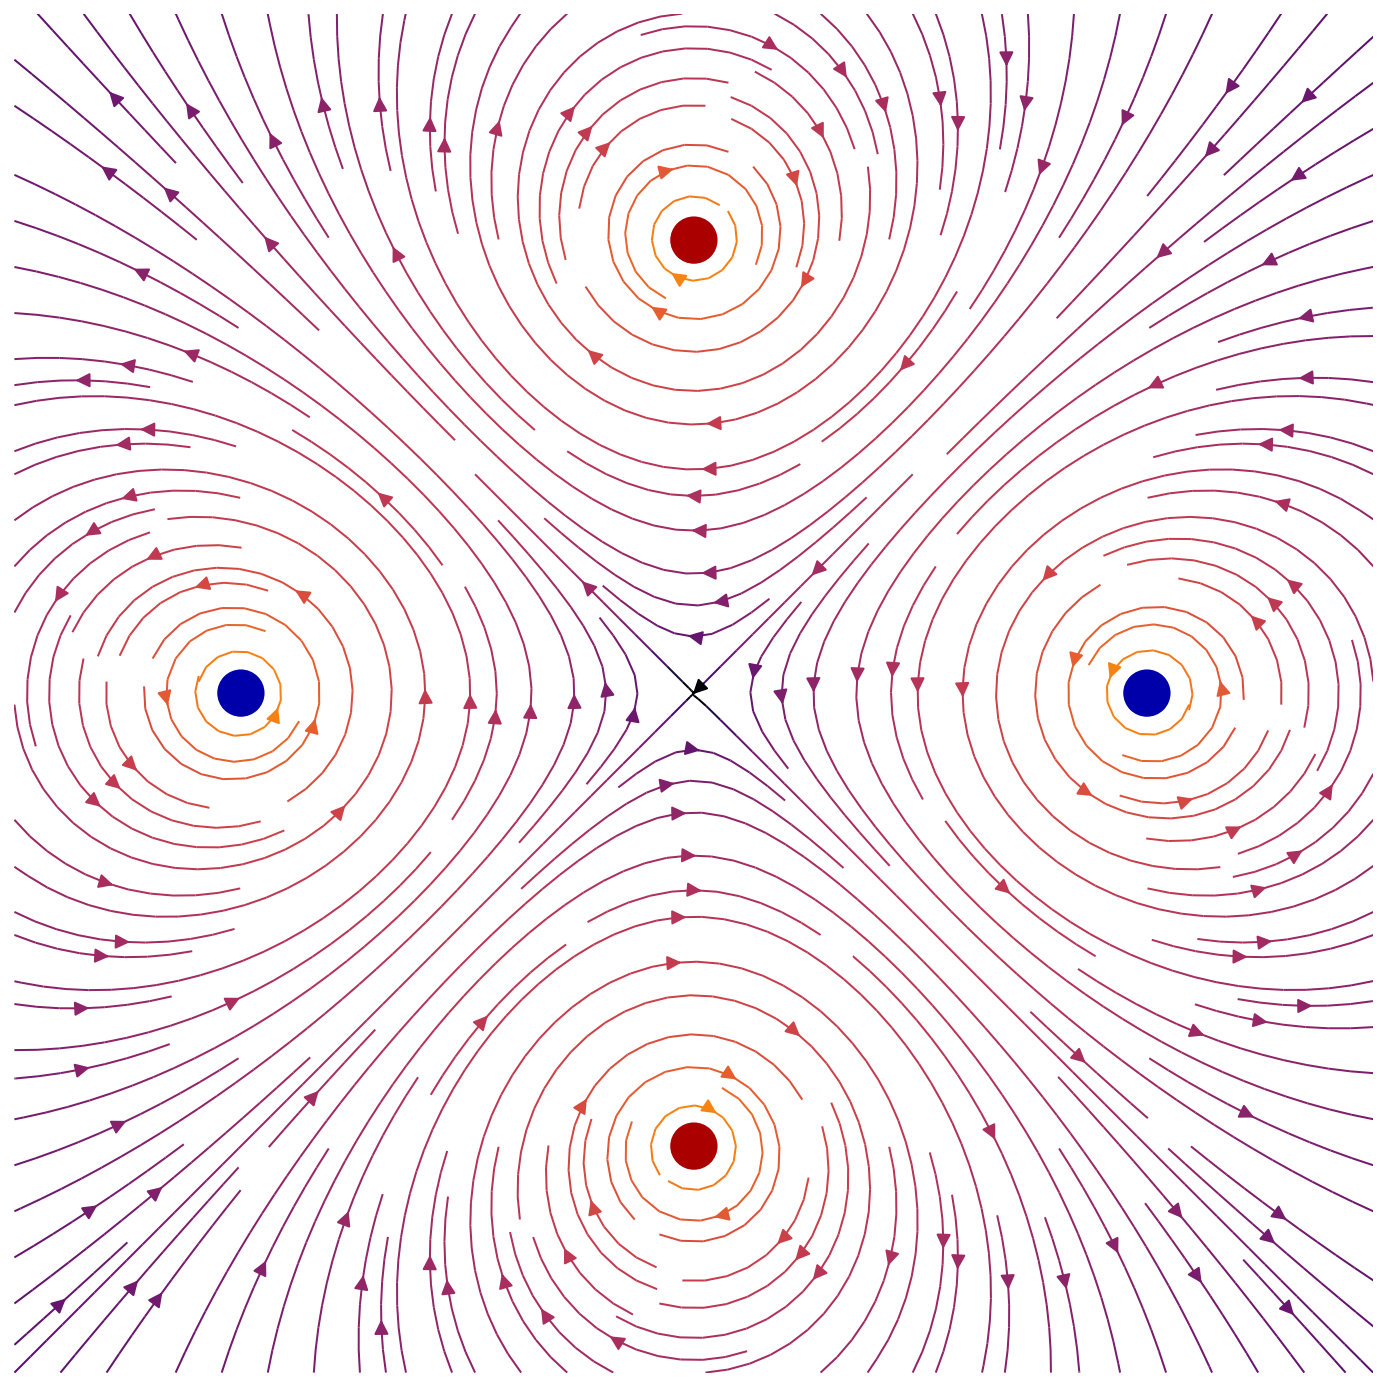

In [8]:
fig = plt.figure(figsize=(20, 12.5))
axis = fig.add_subplot(111)

# Plot the streamlines with an appropriate colormap and arrow style
color = 2 * np.log(np.hypot(Bx, By))
axis.streamplot(x, y, Bx, By, color=color, linewidth=1, cmap=plt.cm.inferno, density=2, arrowstyle="-|>", arrowsize=1.5)

# Add filled circles for the charges themselves
charge_colors = {True: "#aa0000", False: "#0000aa"}
for charge_position, charge in charges.items():
    axis.add_artist(Circle(charge_position, 0.05, color=charge_colors[charge > 0]))

axis.set_aspect("equal")
axis.set_axis_off()

plt.savefig(f"plots/bfield_multipole_order_{order}.pdf", dpi=500)

## Skew Multipole

In [9]:
skew_charges = generate_multipole(order, skew=True)
Ex_skew, Ey_skew = calculate_efield_map(n_x, n_y, skew_charges)
Bx_skew, By_skew = calculate_bfield_map(n_x, n_y, skew_charges)

### Electric Field Map

In [10]:
fig = plt.figure(figsize=(20, 12.5))
axis = fig.add_subplot(111)

# Plot the streamlines with an appropriate colormap and arrow style
color = 2 * np.log(np.hypot(Ex_skew, Ey_skew))
axis.streamplot(x, y, Ex_skew, Ey_skew, color=color, linewidth=1, cmap=plt.cm.inferno, density=2, arrowstyle="-|>", arrowsize=1.5)

# Add filled circles for the charges themselves
charge_colors = {True: "#aa0000", False: "#0000aa"}
for charge_position, charge in skew_charges.items():
    axis.add_artist(Circle(charge_position, 0.05, color=charge_colors[charge > 0]))

axis.set_aspect("equal")
axis.set_axis_off()

plt.savefig(f"plots/efield_skew_multipole_order_{order}.pdf", dpi=500)

### Magnetic Field Map

In [11]:
fig = plt.figure(figsize=(20, 12.5))
axis = fig.add_subplot(111)

# Plot the streamlines with an appropriate colormap and arrow style
color = 2 * np.log(np.hypot(Bx_skew, By_skew))
axis.streamplot(x, y, Bx_skew, By_skew, color=color, linewidth=1, cmap=plt.cm.inferno, density=2, arrowstyle="-|>", arrowsize=1.5)

# Add filled circles for the charges themselves
charge_colors = {True: "#aa0000", False: "#0000aa"}
for charge_position, charge in skew_charges.items():
    axis.add_artist(Circle(charge_position, 0.05, color=charge_colors[charge > 0]))

axis.set_aspect("equal")
axis.set_axis_off()

plt.savefig(f"plots/bfield_skew_multipole_order_{order}.pdf", dpi=500)

## Both together

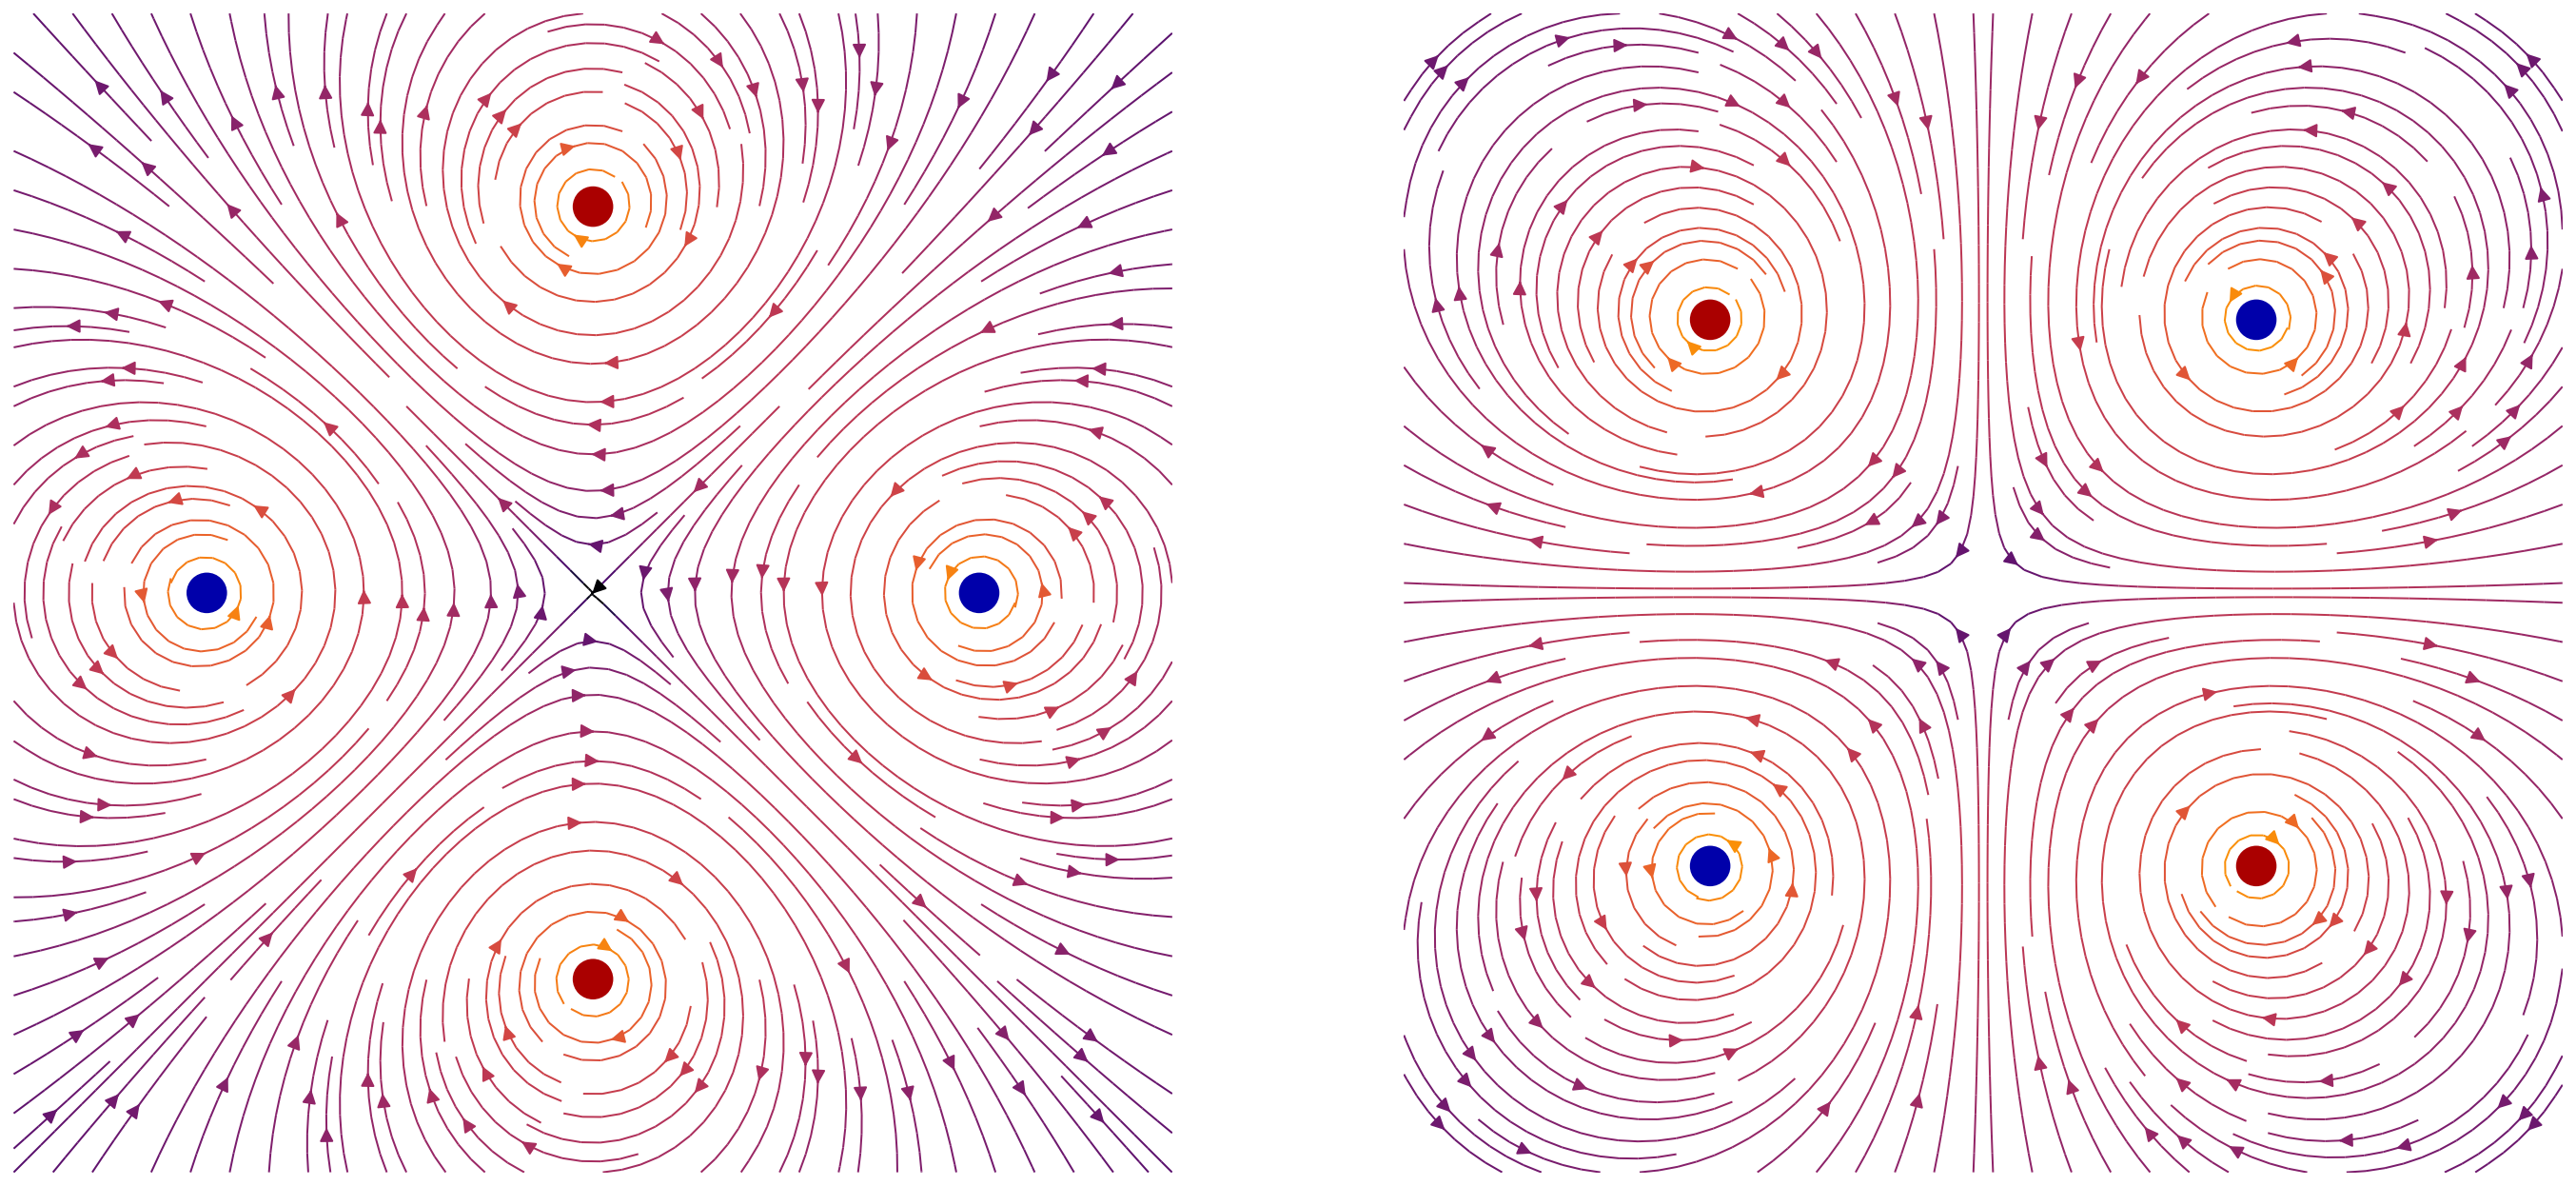

In [12]:
fig, (norm, skew) = plt.subplots(1, 2, figsize=(24, 15))

# Plot the streamlines with an appropriate colormap and arrow style for normal multipole
color = 2 * np.log(np.hypot(Bx, By))
norm.streamplot(x, y, Bx, By, color=color, linewidth=1, cmap=plt.cm.inferno, density=2, arrowstyle="-|>", arrowsize=1.5)

# Add filled circles for the charges themselves
charge_colors = {True: "#aa0000", False: "#0000aa"}
for charge_position, charge in charges.items():
    norm.add_artist(Circle(charge_position, 0.05, color=charge_colors[charge > 0]))

norm.set_aspect("equal")
norm.set_axis_off()

# Plot the streamlines with an appropriate colormap and arrow style
color = 2 * np.log(np.hypot(Bx_skew, By_skew))
skew.streamplot(x, y, Bx_skew, By_skew, color=color, linewidth=1, cmap=plt.cm.inferno, density=2, arrowstyle="-|>", arrowsize=1.5)

# Add filled circles for the charges themselves
charge_colors = {True: "#aa0000", False: "#0000aa"}
for charge_position, charge in skew_charges.items():
    skew.add_artist(Circle(charge_position, 0.05, color=charge_colors[charge > 0]))

skew.set_aspect("equal")
skew.set_axis_off()

plt.savefig(f"plots/bfield_multipole_order_{order}.pdf", dpi=500)

---